In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import random
import time
from tqdm.notebook import tqdm


## KNN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

## Graph
import networkx as nx
from networkx.algorithms.components import is_connected
from networkx.generators.ego import ego_graph

## Preprocessing Aid
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import scipy.sparse as sp
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k, get_top_k_items)
from recommenders.utils.timer import Timer

/Users/samueljon/opt/anaconda3/envs/cs5525/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Statistics & Preprocessing

In [2]:
data = pd.read_csv("source/supporting/goodreads_interactions.csv")

# TESTING MODE
data = data.iloc[0:500000]

In [177]:
# Basic statistics about the dataset
print(f"Total number of entries = {len(data)}")
print(f"Total number of unique users = {len(set(data['user_id']))}")
print(f"Total number of unique books = {len(set(data['book_id']))}")

Total number of entries = 500000
Total number of unique users = 1034
Total number of unique books = 181946


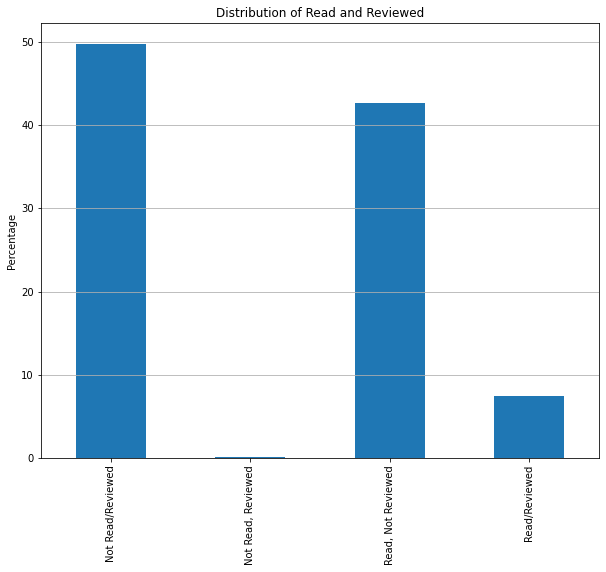

In [3]:
## Distribution of Read and Reviewed
isReadisRev = data.groupby(['is_read','is_reviewed'])['rating'].count()*100/len(data)
isReadisRev.plot(kind='bar', figsize=(10, 8))
plt.xticks(np.arange(4),["Not Read/Reviewed", "Not Read, Reviewed", "Read, Not Reviewed", "Read/Reviewed"])
plt.xlabel("")
plt.ylabel("Percentage")
plt.title("Distribution of Read and Reviewed")
plt.grid(axis="y")
plt.show()

## Focus on read and reviewed only i.e., remove is_reviewed == 0 and rating == 0
data = data[(data['is_reviewed']==1)&(data['rating']!=0)]

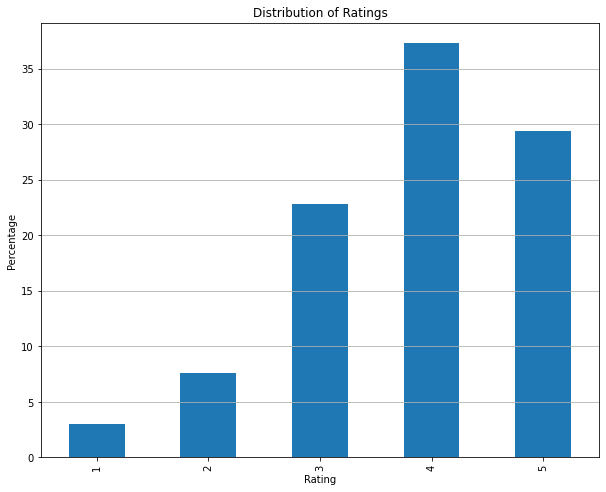

In [4]:
## Distribution of Ratings 
ratings = data.groupby(['rating'])['rating'].count()*100/len(data)
ratings.plot(kind='bar', figsize=(10, 8))
plt.xlabel("Rating")
plt.ylabel("Percentage")
plt.title("Distribution of Ratings")
plt.grid(axis="y")
plt.show()

ratings_per_user = data[(data['is_reviewed']==1)&(data['rating']!=0)].groupby('user_id').size().reset_index(name='number_of_ratings_per_user')


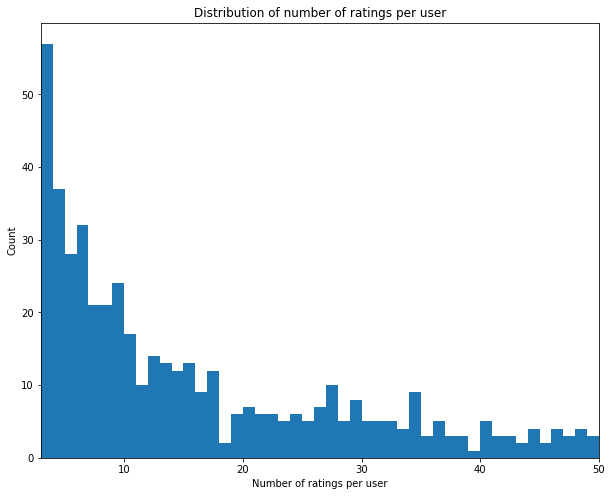

In [5]:
## Distribution of number of books rated per user
fig = plt.figure(figsize=(10,8))
plt.hist(ratings_per_user['number_of_ratings_per_user'], bins=range(3, 51))
plt.xlim(3, 50)
plt.xlabel('Number of ratings per user')
plt.ylabel('Count')
plt.title('Distribution of number of ratings per user')
plt.show()

In [6]:
## Focus on users that have more than 10 book ratings
data = data[data.user_id.isin(set(ratings_per_user[ratings_per_user['number_of_ratings_per_user']>=10]['user_id']))]

## Focus on ratings >= 3  
data = data[data.rating>=3]

## Remove is_reviewed and is_read
data = data[['user_id','book_id','rating']]

# Perform a 80/20 train-test split on the interactions in the dataset
train, test = train_test_split(data.values, test_size=0.2, random_state=17)
train_df = pd.DataFrame(train, columns=data.columns)
test_df = pd.DataFrame(test, columns=data.columns)
print("Train Size  : ", len(train_df))
print("Test Size : ", len (test_df))

Train Size  :  25215
Test Size :  6304


In [7]:
## Relabel IDs train set for both user and book ids
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)
train_df['book_id_idx'] = le_item.fit_transform(train_df['book_id'].values)

## Test items that are only present in the train set (i.e., user and book id that are in train set)
test_df = test_df[(test_df['user_id'].isin(train_df['user_id'].unique())) & (test_df['book_id'].isin(train_df['book_id'].unique()))]

## Relabel IDs for test set for both user and book ids
test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)
test_df['book_id_idx'] = le_item.transform(test_df['book_id'].values)

## Preparing for Micorosft's Input -- requires timestamp even though timestamp isn't used
train_df = train_df[['user_id_idx','book_id_idx','rating']]
train_df.rename(columns={"user_id_idx":"userID", "book_id_idx":"itemID"}, inplace =True)
train_df['timestamp'] = 0

test_df = test_df[['user_id_idx','book_id_idx','rating']]
test_df.rename(columns={"user_id_idx":"userID", "book_id_idx":"itemID"}, inplace =True)
test_df['timestamp'] = 0

## Print number of unique users and books after filter
n_users = train_df['userID'].nunique()
n_items = train_df['itemID'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Books : ", n_items)

Number of Unique Users :  398
Number of unique Books :  20177


In [8]:
## SPARSITY OF TRAINING SET
ratings = pd.pivot_table(train_df, values='rating', index=['userID'],columns=['itemID']).fillna(0)
sparsity = (ratings == 0).sum().sum()
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 99.69%


# Graph Visualization

In [9]:
userNodes = [(i,{'type':'user'}) for i in set(combineDF['user_id_idx'])]
bookNodes = [(i,{'type':'book'}) for i in set(combineDF['book_id_idx']+n_users)]
userbookEdge = list(combineDF.apply(lambda x: (x.user_id_idx, x.book_id_idx+n_users, x.rating), axis=1))

In [10]:
G = nx.Graph()
G.add_nodes_from(userNodes+bookNodes)
G.add_weighted_edges_from(userbookEdge)

In [11]:
print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())

Num nodes: 12747 . Num edges: 15153


In [14]:
## Need to extract a subset of the data for visualization

## Method 1 - Random --> Very Sparse / Not Connected
subgraph = np.random.choice([id for (id, attr) in G.nodes(data=True)], size=1000, replace=False)
subgraph = G.subgraph(subgraph)

## Method 2 - First subSamp Users & their corresponding books
# subSamp = 10
# subgraph = G.subgraph(np.append(np.array(range(subSamp)), list(combineDF[combineDF['user_id_idx']<=subSamp]['book_id_idx']+n_users)))

## Method 3 - Top User w/ Most Books Reviewed, X steps back
# maxUser = list(combineDF.groupby('user_id_idx')['user_id'].count().reset_index().sort_values("user_id", ascending=False)['user_id_idx'])[0]
# subgraph = ego_graph(G, maxUser, 3, undirected=True)
# print('Num nodes:', subgraph.number_of_nodes(), '. Num edges:', subgraph.number_of_edges())


print(f"Is the subgraph connected? {is_connected(subgraph)}")
largest_cc = max(nx.connected_components(subgraph), key=len)
subgraph = nx.Graph(subgraph.subgraph(largest_cc))
print(f"Number of Users in Largest Connected Component of Subgraph: {len(set([label for label, attr in subgraph.nodes(data=True) if attr['type'] == 'user']))}")
print(f"Number of Books in Largest Connected Component of Subgraph: {len(set([label for label, attr in subgraph.nodes(data=True) if attr['type'] == 'book']))}")

Is the subgraph connected? False
Number of Users in Largest Connected Component of Subgraph: 2
Number of Books in Largest Connected Component of Subgraph: 74


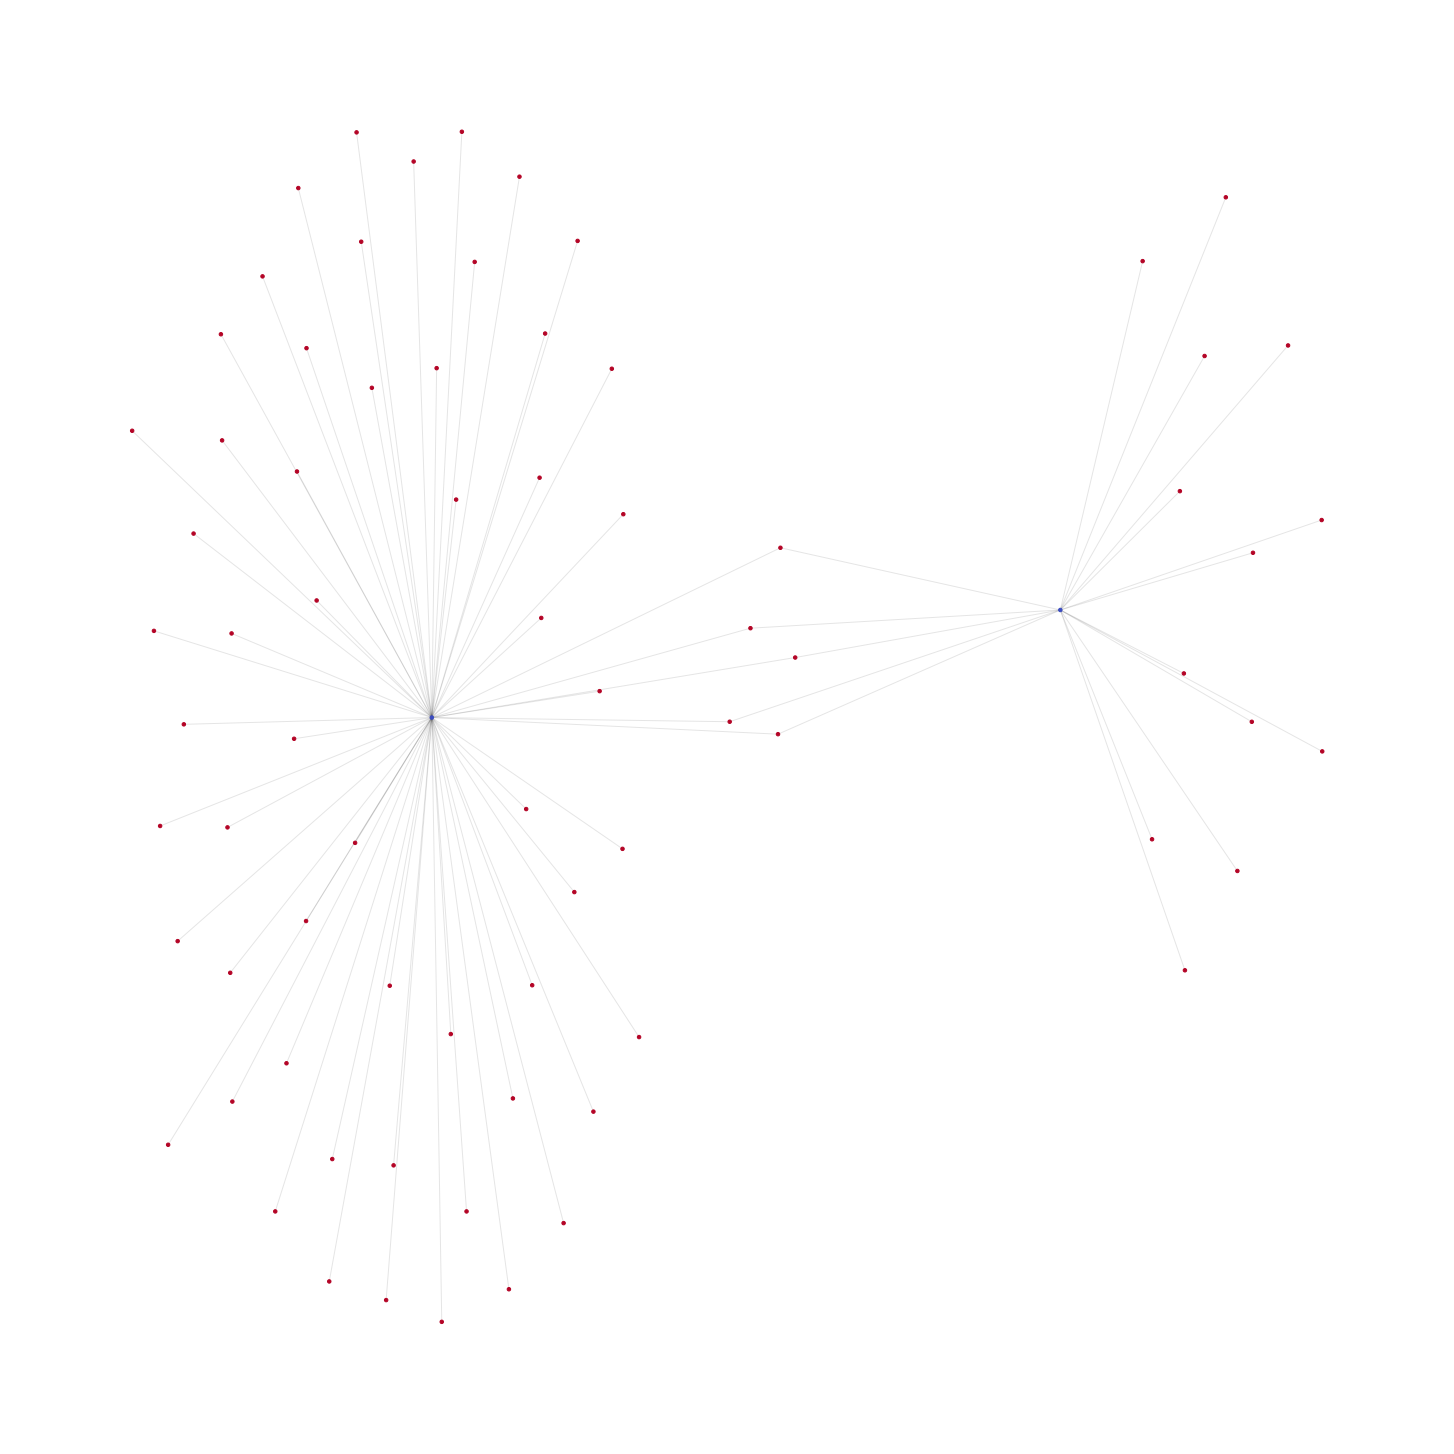

In [15]:
plt.figure(figsize=(20, 20))
color_map = {'user': 0, 'book': 1}
node_color = [color_map[attr['type']] for (id, attr) in subgraph.nodes(data=True)]
nx.draw(subgraph, cmap=plt.get_cmap('coolwarm'), node_color=node_color, node_size=12, width=1, edge_color=(0,0,0,0.1))

# By Popularity

In [22]:
def predictTopKAllRANDOM(train_df, K):
    ratings = pd.pivot_table(train_df, values='rating', index=['userID'],columns=['itemID']).fillna(0)
    ratings[ratings > 0] = 1
    predictions=[]
    for _ in range(len(train_df['userID'].unique())):
        predictions += random.choices(list(ratings.columns), weights=ratings.sum(axis=0)/len(train_df['userID'].unique()), k=K)
    predictions = pd.DataFrame({"userID":np.repeat(train_df['userID'].sort_values().drop_duplicates().values, K),\
                             "itemID":predictions,\
                             "prediction":len(train_df.userID.unique())*list(range(K,0,-1))})
    return predictions 

In [23]:
with Timer() as train_time:
    K = 20
    all_predictions = predictTopKAllRANDOM(train_df, K)
print("Took {} seconds for training.".format(train_time))

Took 8.3201 seconds for training.


In [189]:
eval_map = map_at_k(test_df, all_predictions, col_prediction='prediction', k=K)
eval_ndcg = ndcg_at_k(test_df, all_predictions, col_prediction='prediction', k=K)
eval_precision = precision_at_k(test_df, all_predictions, col_prediction='prediction', k=K)
eval_recall = recall_at_k(test_df, all_predictions, col_prediction='prediction', k=K)
print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.000930
NDCG:	0.002758
Precision@K:	0.000952
Recall@K:	0.005469


In [24]:
eval_map = map_at_k(test_df, all_predictions, col_prediction='prediction', k=K)
eval_ndcg = ndcg_at_k(test_df, all_predictions, col_prediction='prediction', k=K)
eval_precision = precision_at_k(test_df, all_predictions, col_prediction='prediction', k=K)
eval_recall = recall_at_k(test_df, all_predictions, col_prediction='prediction', k=K)
print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.000362
NDCG:	0.001877
Precision@K:	0.001111
Recall@K:	0.004253
